In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def time_averaging_field(array, window=30, normalized=True):
    """Function averages a 3D field in a time window.
    Parameters
    ----------
    array: array
        3D array with dimensions (time, space, space). The time averaging
        happens in axis=0 of the array.
    window: int, optional
        The time window for the averaging. Default value is 30 (days).
    normalized: bool, optional
        Normalizes the average in space, axis=1&2. Default True.
    Returns
    -------
    averaged: array
        time averaged fields dimensions (time//window, space, space).
    time_array:
        1D array showing the window jumps. Its useless...
    """
    nt, nx, ny = array.shape

    new_t_dim = nt//window
    averaged = np.zeros((new_t_dim, nx, ny))
    time_array = np.arange(window, nt, window)

    for t in range(0, new_t_dim):
        index_slice = slice((t)*window, (t+1)*window)
        mean_aux = np.mean(array[index_slice, :, :], axis=0)

        if normalized:
            if mean_aux.sum() == 0:
                print(f'-- mean_aux.sum() = {mean_aux.sum()}')
                averaged[t] = np.zeros_like(mean_aux)
            else:
                averaged[t] = mean_aux/mean_aux.sum()

        else:
            averaged[t] = mean_aux

    # if normalized:
    #     print('--- Normalized?', averaged[-1].sum())

    return averaged, time_array

In [3]:
###############################################################################
# Setting the parameters
###############################################################################
series = 6  # the number of the simulation series
compute_mean = True  # True if you want to compute the average probability
average_window = 1600  # days (or stored time steps from parcels simulations)

print(f'Compute mean == {compute_mean}!')

domain_limits = [[-73, 25], [-80, 0]]
number_bins = (98, 80)  # defined with respect to domain_limits to be 1x1 deg

# generating the lon and lat ranges.
lon_range = np.linspace(domain_limits[0][0], domain_limits[0][1],
                        number_bins[0])
lat_range = np.linspace(domain_limits[1][0], domain_limits[1][1],
                        number_bins[1])

# Loading priors. Computed with release_points.py script.
priors = pd.read_csv('../data/analysis/priors_river_inputs.csv', index_col=0)
sources = list(priors.index)
number_sources = len(sources)

# Empty dictionaries to store computed probabilities.
likelihood = {}
posterior = {}
counts = {}
avg_label = ''  # label to be modified if average is True. Print in output_path

sample_size = 1000
number_samples = 2 # at least 50 up to 100

Compute mean == True!


In [4]:
######################§#########################################################
# Building the histograms
###############################################################################

time_dimensions = []

for loc in sources:
    print(f'- {loc}')
    
    path_2_file = f"../data/simulations/sa-s{series:02d}" + \
        f"/sa-s{series:02d}-{loc}.nc"
    
    particles = xr.load_dataset(path_2_file)
    
    trajectories = particles.dims['traj']
    time = particles.dims['obs']
    time_dimensions.append(time)
    h = np.zeros((number_samples, time, *number_bins))
    
    for i_sample in range(number_samples):
        # Bootstrapping - Resampling with replacement
        resampled_index = np.random.choice(trajectories, sample_size, replace=True) 
        
        for t in range(time):
            lons = particles['lon'][resampled_index, t].values
            index = np.where(~np.isnan(lons))
            lons = lons[index]
            
            lats = particles['lat'][resampled_index, t].values
            lats = lats[index]

            if compute_mean:
                # if true, the histograms are not normalized.
                H, x_edges, y_edges = np.histogram2d(lons, lats,
                                                     bins=number_bins,
                                                     range=domain_limits)
                h[i_sample, t] = H

            else:
                # if false or else, the histograms are normalized, therefore
                # we get directly the likelihood.
                H_norm, x_edges, y_edges = np.histogram2d(lons, lats,
                                                          bins=number_bins,
                                                          range=domain_limits,
                                                          density=True)
                h[i_sample, t] = H_norm

    counts[loc] = h


- Congo
- Cape-Town
- Rio-de-la-Plata
- Porto-Alegre
- Santos
- Paraiba
- Itajai
- Rio-de-Janeiro
- Salvador
- Recife
- Unclustered-Africa
- Unclustered-America


In [5]:
# # Some histograms have shorter time dimension. We select the shortest time
# # of them all.
# time = min(time_dimensions)

# # Compute the total numer of particles per bin per time.
# total_counts = np.zeros((time, *number_bins))
# for loc in sources:
#     total_counts += counts[loc][:time]

In [6]:
###############################################################################
# To average or not to average, that's the question.
###############################################################################
if compute_mean:
    # we average the unnormalized histograms in a time window.
    print('Averaging histograms and computiong likelihood')

    for loc in sources:
        mean_samples = []
        
        for i_sample in range(number_samples):
            mean, time_range = time_averaging_field(counts[loc][i_sample],
                                                    window=average_window)
            mean_samples.append(mean)
        
        mean_samples = np.array(mean_samples)
        likelihood[loc] = mean_samples

#     total_counts, _ = time_averaging_field(total_counts, window=average_window,
#                                            normalized=False)
    time = time//average_window
    avg_label = f'_aw{average_window}'  # average window nummer
# else:
#     # convert counts to likelihood. The counts were normalized in line ~120.
#     likelihood = counts
#     time_range = np.arange(0, time, 1)

# print('total_counts', total_counts.shape)

Averaging histograms and computiong likelihood


In [7]:
likelihood['Rio-de-Janeiro'].shape

(2, 1, 98, 80)

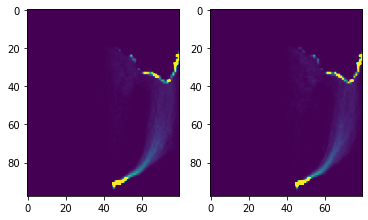

In [8]:
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(likelihood['Cape-Town'][0, 0], vmax=3e-3)

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(likelihood['Cape-Town'][1, 0], vmax=3e-3)

In [9]:
number_samples

2

In [10]:
###############################################################################
# Normalizing constant (sum of all hypothesis)
###############################################################################
print('Computing Normalizing constant')
normalizing_constant = np.zeros((number_samples, time, *number_bins))


for i_sample in range(number_samples):
    for t in range(time):
        # print('norm time', t)
        total = np.zeros((number_samples, number_sources, *number_bins))
        
        for i_sample in range(number_samples):
            for j, loc in enumerate(sources):
                total[i_sample, j] = likelihood[loc][i_sample, t]*priors['prior'][loc]

            normalizing_constant[i_sample, t] = np.sum(total[i_sample], axis=0)

Computing Normalizing constant


In [11]:
normalizing_constant.shape

(2, 1, 98, 80)

In [12]:
time

1

In [14]:
###############################################################################
# Posterior probability
###############################################################################
print('Computing posterior probability')
likelihood_xr = {}  # formatting dictionary for xarray Dataset convertion
for k, loc in enumerate(sources):
    pst = np.zeros((number_samples, time, *number_bins))
    lklhd = np.zeros((number_samples, time, *number_bins))

    for i_sample in range(number_samples):
        t
        for t in range(time):
            # Bayes theorem!
            pst[i_sample, t] = likelihood[loc][i_sample,t]*priors['prior'][loc]/normalizing_constant[i_sample,t]
            lklhd[i_sample, t] = likelihood[loc][i_sample, t]
        # xarray Dataset formatting
        posterior[loc] = pst #(["time", "x", "y"], pst)
        likelihood_xr[i_sample, loc] = lklhd #(["time", "x", "y"], lklhd)  # homgenizing time dim

# posterior['counts'] = (["time", "x", "y"], total_counts)

Computing posterior probability


/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [15]:
#####
# Standard deviation and mean
#####

mean = {}
standard_deviation = {}

for k, loc in enumerate(sources):
    mean[loc] = (["time", "x", "y"], np.mean(posterior[loc], axis=0))
    standard_deviation[loc] = (["time", "x", "y"], np.std(posterior[loc], axis=0))

In [16]:
standard_deviation['Cape-Town']

(['time', 'x', 'y'],
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]))

In [19]:
###############################################################################
# Saving the likelihood & posteior as netCDFs
###############################################################################
coordinates = dict(time=time_range,
                   lon=(["x"], lon_range),
                   lat=(["y"], lat_range))

attributes = {'description': f"Standard deviation Simulatons",
              'average_window': average_window}

# Posterior dataset
ds_post = xr.Dataset(data_vars=standard_deviation,
                     coords=coordinates,
                     attrs=attributes)

output_path_post = f'../analysis/STD_{avg_label}.nc'


ds_post.to_netcdf(output_path_post)
ds_post.close()


In [5]:
std = xr.load_dataset('../data/analysis/STD__aw30_6.nc')

In [10]:
std['Congo'][0]

<xarray.DataArray 'Congo' (x: 98, y: 80)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time     int64 30
    lon      (x) float64 -73.0 -71.99 -70.98 -69.97 ... 21.97 22.98 23.99 25.0
    lat      (y) float64 -80.0 -78.99 -77.97 -76.96 ... -3.038 -2.025 -1.013 0.0
Dimensions without coordinates: x, y

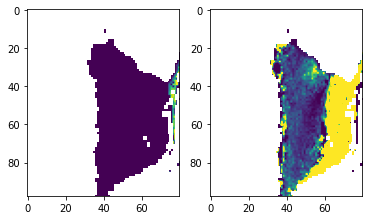

In [16]:
ti = 50

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(std['Congo'][ti], vmax=3e-1)

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(std['Cape-Town'][ti], vmax=3e-2)